In [123]:
import yfinance as yf
import numpy as np
import statistics
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import warnings
warnings.simplefilter('ignore')
PATH_TO_STOCK = 'data/SSE50.csv'

1. Собрать данные по дневным ценам активов (акций) и дневным объемам продаж на заданном фондовом рынке за указанный период. Добавить (если нет) данные по индексу рынка

2. Преобразовать данные по ценам в данные по доходностям (используйте логарифмическую доходность). Вычислите оценки ожидаемых доходностей и стандартных отклонений и постройте «карту» активов в системе координат (σ, E).

3. Рассмотрите портфель с равными долями капитала и отметьте его на карте активов в системе координат (σ, E). Дайте характеристику этому портфелю.

4. Рассмотрите индекс рынка и отметьте его на карте активов в системе координат (σ,E). Дайте характеристику индексу рынка. PS σ - Risk, E - Expectation

In [2]:
def get_descriptive_statistics(frame):
    E = np.mean(frame["Log_R"])
    sigma = np.std(frame["Log_R"])
    frame['E'] = E
    frame['sigma'] = sigma
    return frame, E, sigma

def get_log_R(frame):
    frame['Log_R'] = np.log(frame['Close'] / frame['Close'].shift(1))
    return frame

In [ ]:
stocks_stat = pd.DataFrame(columns=['sigma', 'E', 'names', 'mean_vol', 'mean_log_R', 'industry'])
stocks_info = pd.read_csv(PATH_TO_STOCK, names=['Name', 'Industry','Symbol'], delimiter=',')
n_stocks = len(stocks_info)
stocks = {}

for index, row in stocks_info.iterrows():
    name, industry, symbol = row
    if name != 'Index':
        symbol = str(symbol) + '.SS'
    stock = yf.download(symbol, start="2018-01-01", end="2018-12-31")
    stock = get_log_R(stock)
    stock, E, s = get_descriptive_statistics(stock)
    mean_vol = stock['Volume'].mean()
        
    stocks_stat.loc[index] = [s, E, name, mean_vol, stock['Log_R'].mean(), industry]
    stocks[str(name)] = stock

In [ ]:
fig = px.scatter(stocks_stat, x="sigma", y="E", hover_data=["names"], color="industry",title="E, Risk", size="mean_vol")

E_balanced = stocks_stat['E'].mean()
sigma_balanced = abs(np.sqrt(np.cov(stocks_stat['mean_log_R'])))
vol_balanced = stocks_stat['mean_vol'].mean()

fig.add_trace(go.Scatter(
    x=[sigma_balanced],
    y=[E_balanced],
    mode="markers+text",
    #name="index",
    text='Balanced portfolio',
    textposition="top center"
))
fig.add_trace(go.Scatter(
    x=stocks_stat[stocks_stat.names == 'Index']['sigma'].values,
    y=stocks_stat[stocks_stat.names == 'Index']['E'].values,
    mode="markers+text",
    #name="index",
    text='Index SSE50',
    textposition="top center"
))
fig.show()
# pio.write_html(fig, file='report/fig1.html', auto_open=True)

## 5. Value at Risk

---
    - Задайте уровень риска и оцените VaR (Value at Risk = Сумма под Риском) для активов вашего рынка. 
    - Какой из активов наиболее предпочтителен по этой характеристике? 
    - Где он расположен на карте активов? Дайте характеристику VaR портфеля с равными долями и индекса рынка.
    
---


**Замечание перед рассчетом VaR**: 
1. Расчет VaR полагается на предположение о том, что данные доходностей акций нормально распределены.
2. Следовательно, перед вычислением VaR проанализируем распределение доходностей с помощью *гистограммы+нормальной кривой* и с помощью статистического *теста на нормальность Шапиро-Вилка*. 
3. Также можно посмотреть на описательные статистики распределления, например, среднее и медиана (у нормального распределения эти статистики должны быть близки.

In [200]:
from scipy import stats


assets = list(stocks.keys())
for asset in assets:
    sample = stocks[asset]
    stat, p= stats.shapiro(sample['Log_R'].iloc[1:])
    if p > 0.049:
        print('%s: **Statistics=%.3f, p-value=%.3f**' % (asset, stat, p))

Xinwei Group: **Statistics=1.000, p-value=1.000**
Ping An Insurance: **Statistics=0.992, p-value=0.248**
New China Life Insurance: **Statistics=0.990, p-value=0.102**
China Pacific Insurance: **Statistics=0.990, p-value=0.087**


In [202]:
chosen_asset = 'Ping An Insurance'
sample = stocks[chosen_asset]
stat, p= stats.shapiro(sample['Log_R'].iloc[1:])
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

Statistics=0.992, p-value=0.248


In [203]:
sample['Log_R'].describe()

count    242.000000
mean      -0.001065
std        0.019945
min       -0.068382
25%       -0.012542
50%       -0.000782
75%        0.011682
max        0.049514
Name: Log_R, dtype: float64

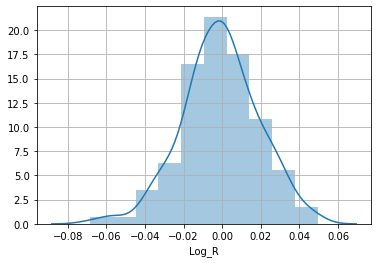

In [204]:
import seaborn as sns
plt.grid()
sns.distplot(sample['Log_R'], bins=10)
plt.show()

**1.  Variance-Covariance approach for one asset**

In [205]:
from scipy.stats import norm

confidence_lvl = [0.9, 0.95, 0.99]

VaR = {}

print('VaR for %s:' % chosen_asset)
for clvl in confidence_lvl:
    VaR[clvl] = norm.ppf(1-clvl, sample['Log_R'].mean(), sample['Log_R'].std())
    print(' - Loss will not exceed %.4f  with %.2f%s confidence.' % (VaR[clvl], clvl, '%'))

VaR for Ping An Insurance:
 - Loss will not exceed -0.0266  with 0.90% confidence.
 - Loss will not exceed -0.0339  with 0.95% confidence.
 - Loss will not exceed -0.0475  with 0.99% confidence.


**Комментарий**: 
1. Итак, видим, что для того, чтобы рассчитать VaR методом Variance-Covariance достаточно использовать point percentile function (ppf) нормального распределения, которая посчитая нам по заданной вероятности точку на оси абсцисс графика нормального распределения с заданными средним и дисперсией (полученными по выборке).
2. Более подробное объяснение есть в [Методы-и-алгоритмы-финансовой-математики](https://vk.com/doc136761433_569070591?hash=bfb7543c4fc46de90d&dl=8a67bf04c0efe170cd) на стр. **599**

In [218]:
# посчитаем VaR для всех активов (данным методом), предполагая, что они нормально распределены

for asset in assets:
    sample = stocks[asset]
    for clvl in confidence_lvl:
        ind = stocks_stat[stocks_stat.names == asset ].index[0]
        stocks_stat.at[ind, 'VaR_'+str(clvl)] = norm.ppf(1-clvl, 
                                                                               sample['Log_R'].mean(), 
                                                                               sample['Log_R'].std())

In [232]:
# получим самые привлекательные активы, основываясь на VaR (у них наименьшие предполагаемые потери)

stocks_stat.sort_values(['VaR_0.95'], ascending=[False]).head(5)

,sigma,E,names,mean_vol,mean_log_R,industry,VaR_0.9,VaR_0.95,VaR_0.99
9,0.011458,-0.001020,Bank of Beijing,3.756217e+07,-0.001020,Banking,-0.015734,-0.019905,-0.027730
12,0.012251,-0.000336,Bank of Communications,9.692052e+07,-0.000336,Banking,-0.016068,-0.020528,-0.028895
7,0.012119,-0.000910,Bank of Jiangsu,3.255697e+07,-0.000910,Banking,-0.016473,-0.020885,-0.029161
5,0.012233,-0.000886,China Minsheng Bank,8.009104e+07,-0.000886,Banking,-0.016596,-0.021049,-0.029404
15,0.013035,-0.000403,Bank of China,1.560815e+08,-0.000403,Banking,-0.017142,-0.021888,-0.030789


![](img/bestVaR.png)

**2. Historical Simulation approach**

подход заключается в следующем: 
 1. Вычисляем доходности 
 2. Сортируем доходности от худшего к лучшему
 3. Вычисляем кумулятивную функцию
  <br> *=>* VaR с 90% уровнем это 10%


In [233]:
chosen_asset = 'Ping An Insurance'
sample = stocks[chosen_asset]

sample = sample.sort_values(['Log_R'], ascending=[True]).dropna()

In [238]:
print('VaR for %s:' % chosen_asset)
for clvl in confidence_lvl:
    VaR[clvl] = sample.Log_R.quantile(1-clvl)
    print(' - Loss will not exceed %.4f  with %.2f%s confidence.' % (VaR[clvl], clvl, '%'))

VaR for Ping An Insurance:
 - Loss will not exceed -0.0259  with 0.90% confidence.
 - Loss will not exceed -0.0348  with 0.95% confidence.
 - Loss will not exceed -0.0557  with 0.99% confidence.


**Замечание**: 
    1. Как вы можете увидеть здесь есть значительная разница между посчитанными VaR по методу двум методам, это может говорить о том, что распределение не нормальное.